# Conference on: Geomteric Science of Information - 2023
---

#### Imports & Seed Setting

In [21]:
import math
import numpy as np
import pandas as pd
from scipy.linalg import expm, logm, sqrtm, sinm, cosm
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(2023)
np.random.seed(2023)

import warnings
warnings.filterwarnings("ignore")

#### Hyperparamters

In [2]:
D = 2
dt = .01
N = 10**3

N_samples_sim = 10**2

### Dynamics

#### Drift
$$
\mu_t = A(\cos(t))_{i=1}^D
$$

In [3]:
# Random Linear Mixing
A = np.random.normal(loc=0,scale = 1, size = np.array([D,D]))
A = expm(A) 

# Drift
def drift(t):
    x_out = np.cos(t)*np.ones(D)
    x_out = A.dot(x_out)
    return x_out

### Diffusion/Volatility
$$
\sigma_t = (\cos\bullet (t(1,\dots,D^2)) + I_D),
$$
where $\bullet$ denotes component-wise composition.

In [4]:
# Define Frequences from 1 to D^2; on which the sine function will be applies x time
Frequencies = np.linspace(start = 1, stop = (D**2), num=(D**2))
Frequencies = Frequencies.reshape((D,D))

# Diffusion
def diffusion(t):
    x_out = np.cos(t*Frequencies)
    x_out = expm(x_out)
    x_out = x_out + np.eye(D)
    return x_out

### Simulate Several Ito Processes and Their Empirical Laws

In [5]:
# Tranjectory Arrary
Means_history = np.zeros(np.array([D,N]))
Cov_history = np.zeros(np.array([D**2,N]))

# Tranjectory Arrary
TS_history = np.zeros(np.array([D,N+1]))

# Write Time Axis
time_axis = np.linspace(start=0,stop=1,num=(1+N))

# Intialize State
initial_state = np.zeros(D)
TS_history[:, 0] = initial_state

# Initialize Loop
current_state  = initial_state
# Loop: Euler Scheme
for n in range(N):
    # Identify timestep
    t = n*dt
    # Evaluate Drift and Diffusion
    Drift_t = drift(t)
    Diffusion_t = diffusion(t)

    # Generate Noise
    noise = np.random.normal(loc=0,scale=np.sqrt(dt),size=D)

    # Update Random Stae
    current_state = current_state + Drift_t*dt + Diffusion_t.dot(noise)
    
    
    #####################################################
    ########   Update Distributional Estimates   ########
    #####################################################
    # Initialize Samples for Current State of SDE
    Samples_Generated_internalloop = np.zeros(np.array([D,N_samples_sim]))
    # Get Samples
    for i in range(N_samples_sim):
        # Generate Noise
        resampling_noise = np.random.normal(loc=0,scale=np.sqrt(dt),size=D)
        # Update Random State
        resampling_current_state = current_state + Drift_t*dt + Diffusion_t.dot(resampling_noise)
        # Generate Samples
        Samples_Generated_internalloop[:,i] = resampling_current_state

    # Compute Empirical Mean and Empirical Covariance (Fit Gaussian to Samples)
    samples_mean = np.mean(Samples_Generated_internalloop.T, axis=0)
    samples_cov = np.cov(Samples_Generated_internalloop.T, rowvar=0)

    # Update Record
    Means_history[:, n] = samples_mean
    Cov_history[:, n] = logm(samples_cov).reshape(-1,)
    #####################################################
    ######   Update Distributional Estimates - END   ####
    #####################################################

    TS_history[:, (1+n)] = current_state
    
## Write Input Data
input_data = np.vstack([TS_history, time_axis]).T
input_data = np.delete(input_data, (0), axis = 0)
output_data = np.vstack([Means_history, Cov_history]).T

### Visualize Simulated Ito Process

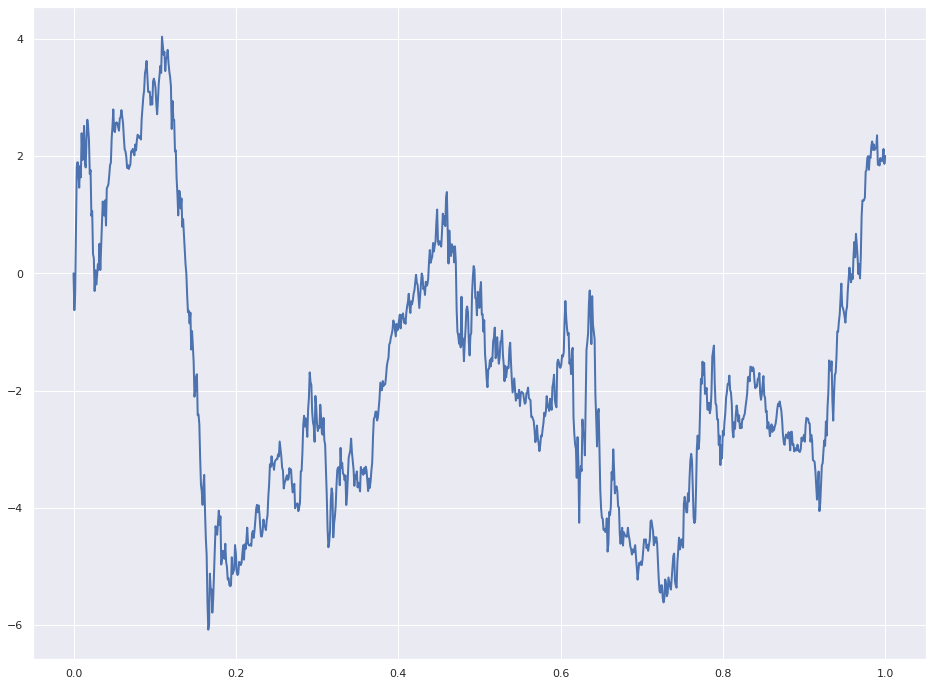

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.plot(time_axis, TS_history[1,:], lw=2)

---

---

## Random Neural Network Regression

In [7]:
from sklearn.linear_model import LinearRegression

#### Initialize Random Feature Map

In [8]:
# Feature Space's Dimension
dim_feature = 10**4

# Radius for sampling random weights
radius_weights = 0.25 # <- Should be positive
# Radius for sampling random biases
radius_bias = 1.1 # <- Should be bigger than 1

dim_data = input_data.shape[1] # <- Number of covariates

#### Helper Function: Uniform Sampler
This next bit of code generate the random feature model of [Gonon et al. 2022 - "Approximation Bounds for Random Neural Networks and Reservoir Systems"](https://arxiv.org/abs/2002.05933)

In [9]:
def random_ball(num_points = dim_feature, dimension=dim_data, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

# Generate the random parameters determining our feature map
rand_weights = random_ball(radius=radius_weights)
rand_biases = random_ball(dimension = 1,radius=radius_bias)



def rand_feature_map(x_input):
    x_int = np.array(x_input).transpose()
    #Apply Random Weights
    x_int = rand_weights.dot(x_int).transpose()
    #Apply Random Bias
    x_int = x_int + rand_biases.transpose()
    #Apply ReLU activation function
    x_int = np.maximum(x_int,0)
    #Return Random Features
    return x_int

Convert inputs to random features

In [10]:
#Apply to each data
## first to the training dataset
X_Rand_Features_train = rand_feature_map(input_data)
X_Rand_Features_train = pd.DataFrame(X_Rand_Features_train)
# ## then to the testing dataset
# X_Rand_Features_test = rand_feature_map(X_test)
# X_Rand_Features_test = pd.DataFrame(X_Rand_Features_test)

#### Get linear regressor (i.e. train the (conditionally) non-random last affine layer of the neural network model)

In [11]:
model_linReg_randfeatures = LinearRegression()
model_linReg_randfeatures.fit(X_Rand_Features_train, output_data)

LinearRegression()

In [12]:
LinearizedPredictions = model_linReg_randfeatures.predict(X_Rand_Features_train)

#### Predicted Means

In [13]:
Means_Predicted = LinearizedPredictions[:, range(D)]
Errors_Means = np.sqrt(np.mean((Means_Predicted - Means_history.T)**2))
print('Error Made When Predicting Means:'+str(round(Errors_Means,5)))

Error Made When Predicting Means:0.0


#### Predicting Covariances
Evaluation Metric
$$
        \mathcal{W}_2^2\big(
            \mathcal{N}_D(\mu_1,\Sigma_1)
        ,
            \mathcal{N}_D(\mu_2,\Sigma_2)
        \big) 
    = 
        \| \mu_1 - \mu_2 \|^2 + \operatorname{tr} \big( \Sigma_1 + \Sigma_2 - 2 ( \Sigma_2^{1/2} \Sigma_1 \Sigma_2^{1/2} )^{1/2} \bigr)
$$

In [25]:
# Helper function implementing the covariance distance part of the 2-Wasserstein distance
def W2_Cov_dist(Sigma_1,Sigma_2):
    W2_out = Sigma_1 + Sigma_2 - 2*np.trace(sqrtm((np.matmul(np.matmul(sqrtm(Sigma_2),Sigma_1),sqrtm(Sigma_2)))))
    return W2_out

In [18]:
# Extract Covariances
Covs_Predicted__Linearized = LinearizedPredictions[:, range(D,(D+(D**2)))]
Cov_history=Cov_history.T # <- Collusion (R Style :P)

In [28]:
#Initialize Error Tabulators

cum_error_Frob = 0
cum_error_W2 = 0

# Computer Mean Errors for: Frobenius and Covariance part of 2-Wasserstein
for j in range(N):
    Predicted_Cov_loop = expm(Covs_Predicted__Linearized[j, :].reshape([D,D]))
    Cov_history_target_loop = (Cov_history[j,:])
    Cov_history_target_loop = expm(Cov_history_target_loop.reshape([D,D]))

    cum_error_Frob = cum_error_Frob + np.sqrt(np.mean((Cov_history_target_loop - Predicted_Cov_loop)**2))
    cum_error_W2 = cum_error_W2 + W2_Cov_dist(Predicted_Cov_loop,Cov_history_target_loop)
# Normalize
cum_error_Frob = cum_error_Frob/N

print('Error (Frobenius) Made When Predicting Means:'+str(round(cum_error_Frob,5)))
print('Error (2-Wasserstein_Covariance Part) Made When Predicting Means:'+str(round(cum_error_Frob,5)))

Error (Frobenius) Made When Predicting Means:0.0
Error (2-Wasserstein_Covariance Part) Made When Predicting Means:0.0
